# **\[SOLAR_A\]** GConvLSTM (수정 및 시뮬레이션)

JiyunLim  
2023-08-27

# 문제상황?

`-` 결과 (batch size=24)

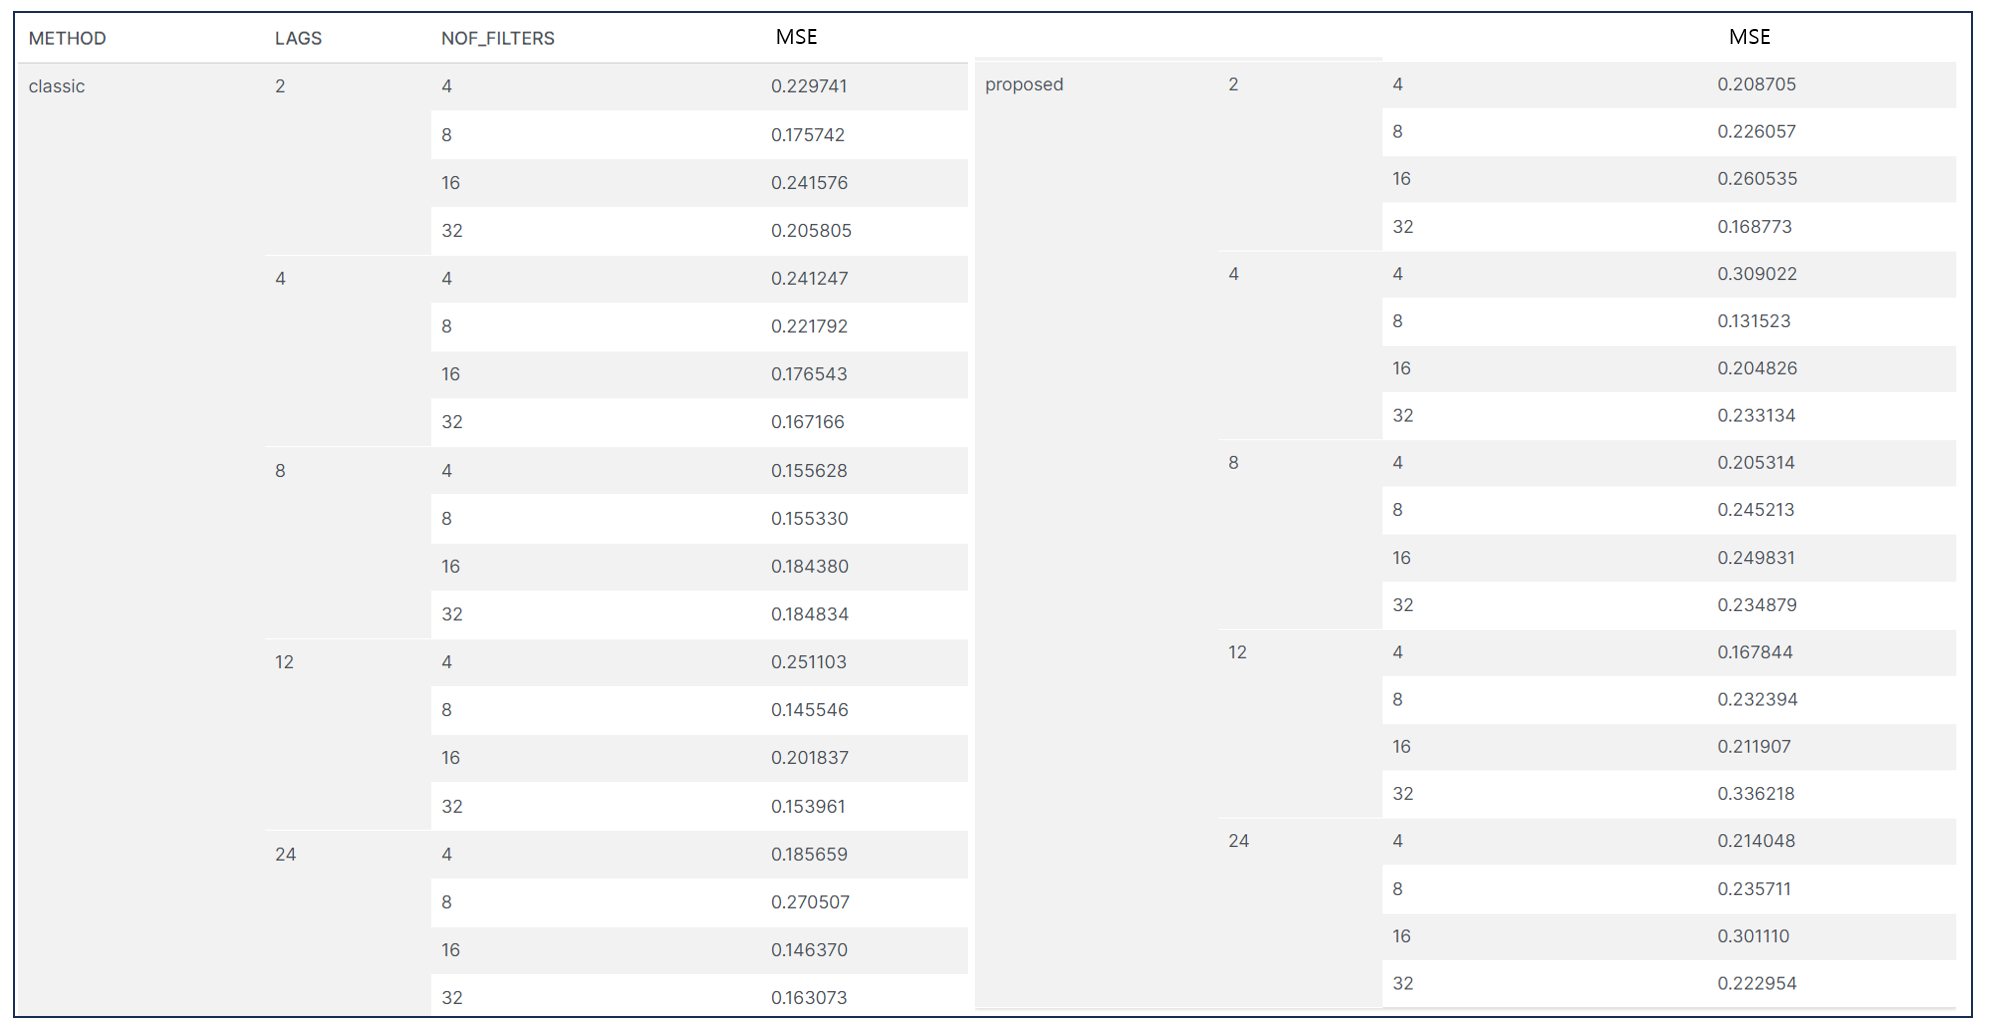

-   에폭을 늘려도 개선이 안됐음.

<figure class="margin-caption">
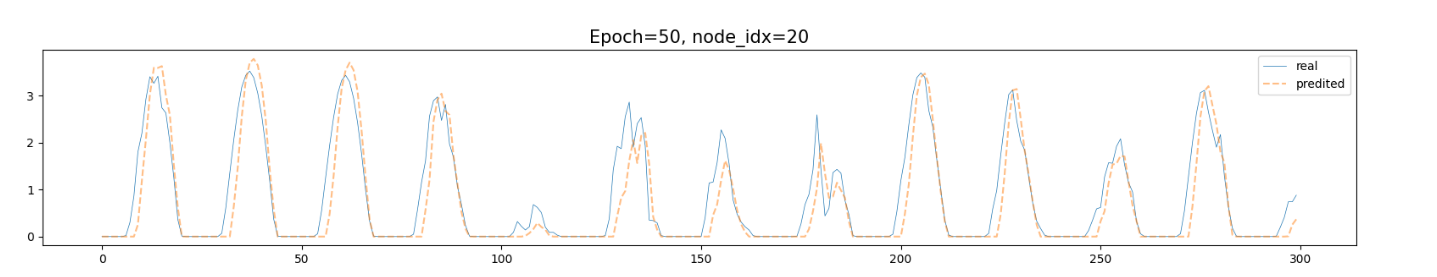
<figcaption aria-hidden="true">proposed method의 학습결과를
시각화</figcaption>
</figure>

# 일부수정 (2023-08-24)

> 모델의 파라미터를 **lag=24** , batch size = 128로 수정하였다.

In [86]:
# modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pytorch geometric temporal
import torch_geometric_temporal
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.nn.recurrent import GConvLSTM

# torch
import torch
import torch.nn.functional as F


# read data
def makedict(FX,W=None,node_ids=None):
    T,N = np.array(FX).shape
    if W==None:
        W = pd.DataFrame(FX).corr().to_numpy().reshape(-1).tolist() # corr 로 weights
    if node_ids==None:
        node_ids = ['node'+str(n) for n in range(N)]
    _dict={
        'edges':[[i,j] for i in range(N) for j in range(N)], 
        'node_ids': node_ids,
        'weights':W,
        'FX':FX
    }
    return _dict

class Loader(object):
    def __init__(self, data_dict):
        self._dataset = data_dict
    
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        # self._edge_weights = np.array(self._dataset["weights"]).T
        edge_weights = np.array(self._dataset["weights"]).T
        #scaled_edge_weights = minmaxscaler(edge_weights)
        self._edge_weights = edge_weights

    def _get_targets_and_features(self):
        stacked_target = np.stack(self._dataset["FX"])
        self.features = np.stack([
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])
        self.targets = np.stack([
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ])


    def get_dataset(self, lags: int = 4) -> StaticGraphTemporalSignal:
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        dataset.node_ids = self._dataset['node_ids']
        return dataset
    

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

class RGCN_Learner:
    def __init__(self):
        self.method = 'RecurrentGCN'
        self.figs = []
        self.epochs = 0
        self.losses = []
        self._node_idx = 0
    def load(self,y): 
        if (self.lags is None) or (self.train_ratio is None):
            self.lags = 2 
            self.train_ratio = 0.8 
        self.t,self.n = y.shape
        dct = makedict(FX=y.tolist())
        self.loader = Loader(dct)
        self.dataset = self.loader.get_dataset(lags=self.lags)
        self.X = torch.tensor(self.dataset.features).float()
        self.y = torch.tensor(self.dataset.targets).float()
        self.train_dataset, self.test_dataset = temporal_signal_split(self.dataset, train_ratio = self.train_ratio)
        self.len_test = self.test_dataset.snapshot_count
        self.len_tr = self.train_dataset.snapshot_count
    def get_batches(self, batch_size=256):
        num_batches =  self.len_tr // batch_size + (1 if self.len_tr % batch_size != 0 else 0)
        self.batches = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = start_idx + batch_size
            self.batches.append(self.train_dataset[start_idx:end_idx])
    
    def learn(self,epoch=1):
        self.model.train()
        for e in range(epoch):
            losses_batch = []
            for b,batch in enumerate(self.batches):
                loss = 0
                self.h, self.c = None, None
                for t, snapshot in enumerate(batch):
                    snapshot = snapshot.to(device)
                    yt_hat, self.h, self.c = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)
                    loss = loss + torch.mean((yt_hat.reshape(-1)-snapshot.y.reshape(-1))**2)
                    print(f'\rbatch={b}\t t={t+1}\t loss={loss/(t+1)}\t', end='', flush=True)
                loss = loss / (t+1)
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses_batch.append(loss.item())
            self.epochs = self.epochs + 1
            print(f'\repoch={self.epochs}\t loss={np.mean(losses_batch)}\n', end='', flush=True)
        self.losses.append(np.mean(losses_batch))
        self._savefigs() 
    def _savefigs(self): 
        self.__call__()
        self._node_idx
        with plt.style.context('default'): 
            plt.ioff()
            plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
            fig,ax = plt.subplots()
            ax.plot(self.y[:,self._node_idx],label='real',lw=0.5)
            ax.plot(self.yhat[:,self._node_idx],'--',label='predited',alpha=0.5)
            ax.set_title(f'Epoch={self.epochs}, node_idx={self._node_idx}',size=15)
            ax.legend()
            #mplcyberpunk.add_glow_effects()  
        self.figs.append(fig)
        plt.close()        
    def __call__(self,dataset=None):
        if dataset == None: 
            dataset = self.dataset
        self.yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, self.h, self.c)[0] for snapshot in dataset]).detach().squeeze().float()
        return {'X':self.X, 'y':self.y, 'yhat':self.yhat} 


def rslt_plot(y, yhat, t_end=None, node_idx = None):
    with plt.style.context('default'):
        plt.ioff()
        plt.rcParams['figure.figsize'] = [20, 3]  # [가로 크기, 세로 크기]
        node_idx = 0 if node_idx is None else node_idx
        t_end = lrnr.t if t_end is None else t_end
        fig,ax = plt.subplots()
        ax.plot(y[:t_end, node_idx], label='real', lw=0.5)
        ax.plot(yhat[:t_end, node_idx], '--', label='predicted', alpha=0.5)
        ax.set_title(f'Epoch = {lrnr.epochs}, node_idx = {node_idx}', size=15)
        ax.legend()

In [87]:
class GConv_LSTM(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(GConv_LSTM, self).__init__()
        self.recurrent = GConvLSTM(in_channels = node_features, out_channels = filters, K = 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        h = F.relu(h_0)
        h = self.linear(h)
        return h, h_0, c_0

## Load data

In [3]:
# read dataframe 
df = pd.read_csv('data_eng_230710.csv')

# make y, y_upper, y_period, time, regions 
y = df.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
yU = df.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
yP = np.divide(y, yU+1e-10)

t = df.loc[:,'date']
regions = list(df.loc[:, 'Bukchoncheon':'Gyeongju-si'].columns)

In [4]:
# global parameters
TRAIN_RATIO = 0.8
T, N = len(t), len(regions)
LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
LEN_TR = T - LEN_TEST

## sample codes

`-` y를 학습

In [6]:
# step1: create lrnr object
lrnr = RGCN_Learner()
# step2: load data 
lrnr.lags = 24
lrnr.train_ratio = 0.8
lrnr.load(y) 
# step3: construct networks 
lrnr.nof_filters = 16
lrnr.model = GConv_LSTM(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(),lr=50/1000)
# step4: learn 
lrnr.get_batches(batch_size=128)

for e in range(5):    
    lrnr.learn()

epoch=1  loss=0.4533438151702285751125336   
epoch=2  loss=0.1800444768741727807125092   
epoch=3  loss=0.1119993133470416382329941       
epoch=4  loss=0.1000111885368824794532776       
epoch=5  loss=0.0943773561157286295946121   

In [7]:
yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
yhat[yhat<0] = 0

In [8]:
np.mean((y - yhat)[LEN_TR:,:]**2)

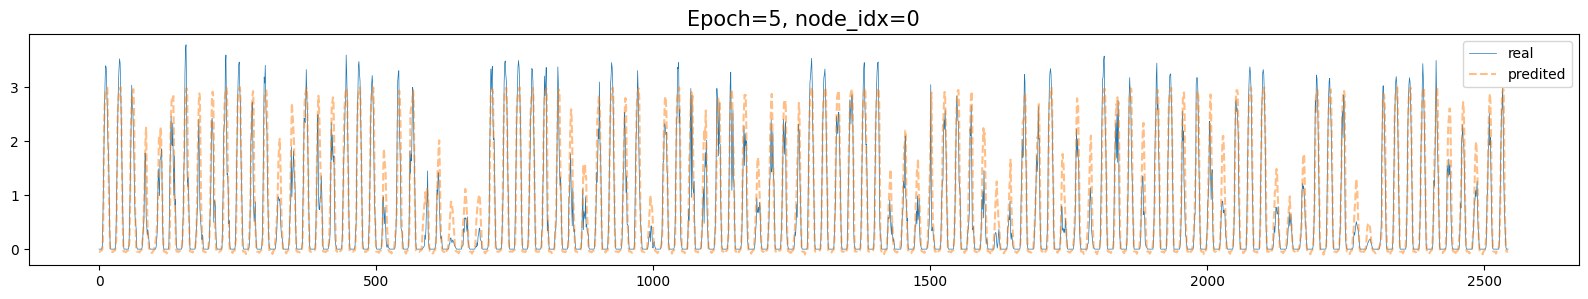

In [9]:
lrnr.figs[-1]

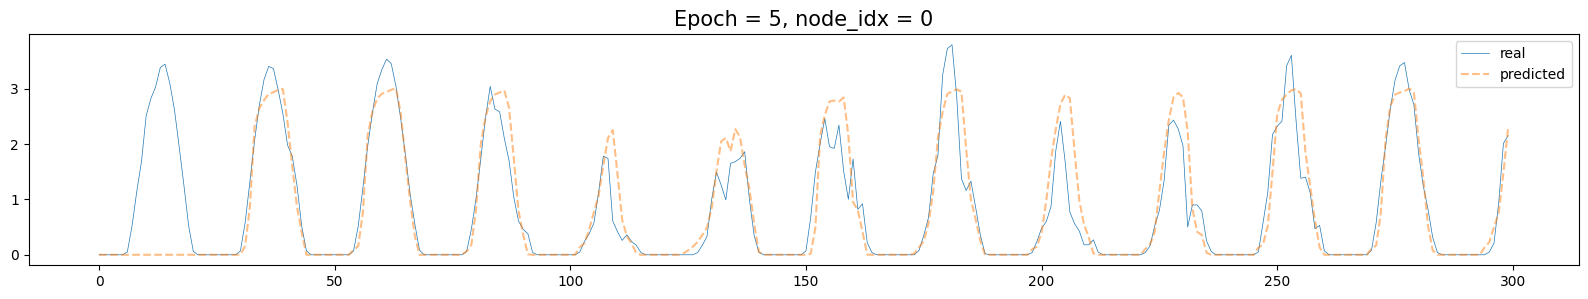

In [10]:
rslt_plot(y, yhat, 300) # y, yhat, t_end, node_idx

`-` yU 학습

In [ ]:
# step1: create lrnr object
lrnr1 = RGCN_Learner()
# step2: load data 
lrnr1.lags = 24 
lrnr1.train_ratio = 0.8
lrnr1.load(yU) 
# step3: construct networks 
lrnr1.nof_filters = 16
lrnr1.model = GConv_LSTM(node_features=lrnr1.lags, filters=lrnr1.nof_filters).to(device)
lrnr1.optimizer = torch.optim.Adam(lrnr1.model.parameters(),lr=10/1000)
# step4: learn 
lrnr1.get_batches(batch_size=24*2)
for e in range(5):    
    lrnr1.learn()

epoch=1  loss=2.3254686129647633813797          
epoch=2  loss=0.522101361391156317349243    
epoch=3  loss=0.42621031299579976634552     
batch=40     t=1     loss=0.24178379774093628       

In [29]:
yUhat = np.concatenate([np.array([list(lrnr1.yhat[0])]*lrnr1.lags),lrnr1.yhat],axis=0)

In [30]:
yU_mse = np.mean((yU - yUhat)[LEN_TR:,:]**2)
yU_mse

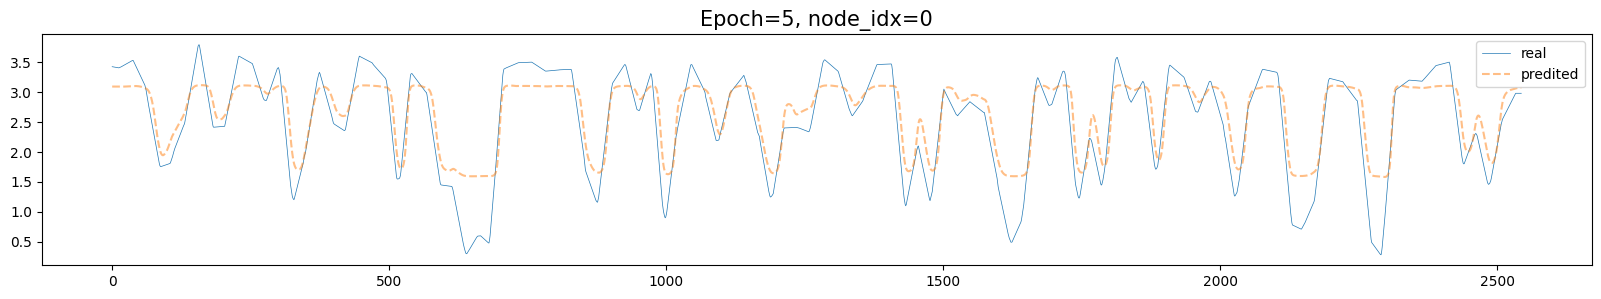

In [31]:
lrnr1.figs[-1]

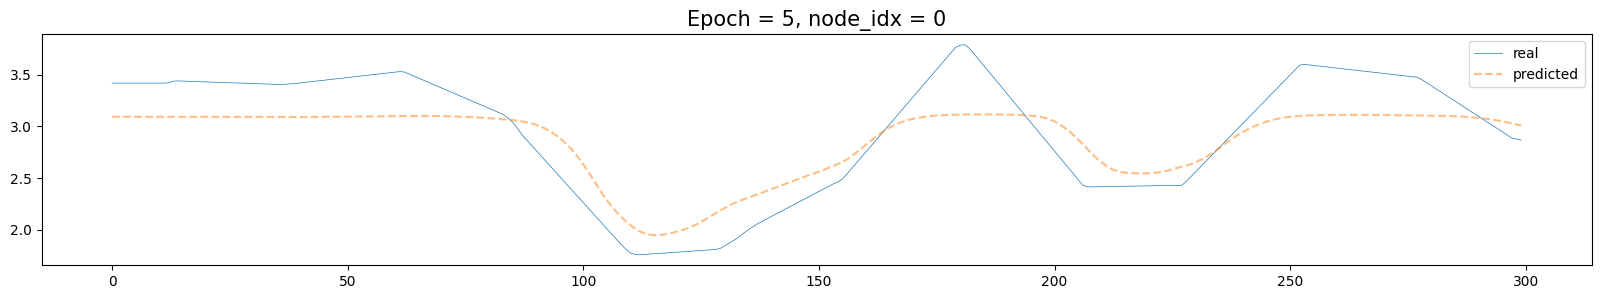

In [32]:
rslt_plot(yU, yUhat, 300)

`-` yP 학습

In [16]:
# step1: create lrnr object
lrnr2 = RGCN_Learner()
# step2: load data 
lrnr2.lags = 24 
lrnr2.train_ratio = 0.8
lrnr2.load(yP) 
# step3: construct networks 
lrnr2.nof_filters = 16
lrnr2.model = GConv_LSTM(node_features=lrnr2.lags, filters=lrnr2.nof_filters).to(device)
lrnr2.optimizer = torch.optim.Adam(lrnr2.model.parameters(),lr=50/1000)
# step4: learn 
lrnr2.get_batches(batch_size=128)
for e in range(5):    
    lrnr2.learn()

epoch=1  loss=0.03953905869275331548127937  
epoch=2  loss=0.01642067736247554455723286  
epoch=3  loss=0.01344401366077363550364399  
epoch=4  loss=0.0123008500377181928728447       
epoch=5  loss=0.01139129049261100629300785  

In [17]:
yPhat = np.concatenate([np.array([list(lrnr2.yhat[0])]*lrnr2.lags),lrnr2.yhat],axis=0)
yPhat[yPhat<0] = 0

In [18]:
yP_mse = np.mean((yP - yPhat)**2)
yP_mse

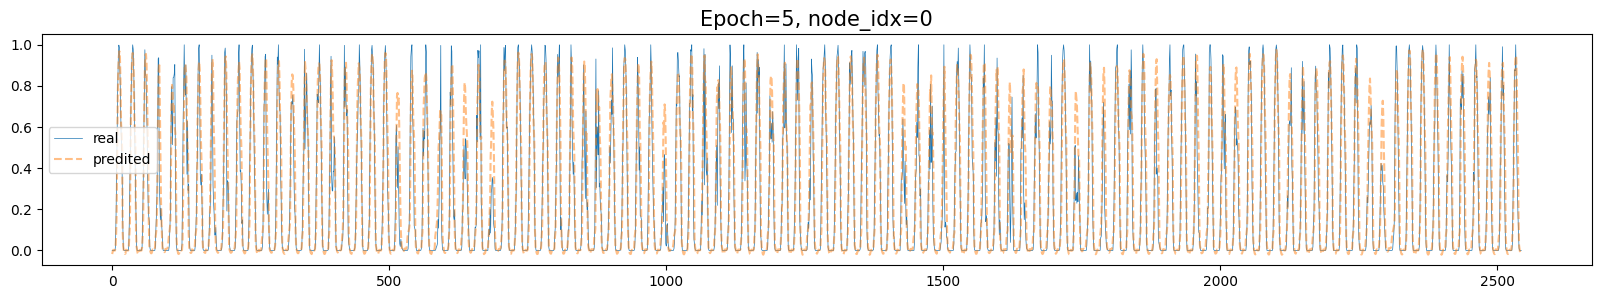

In [19]:
lrnr2.figs[-1]

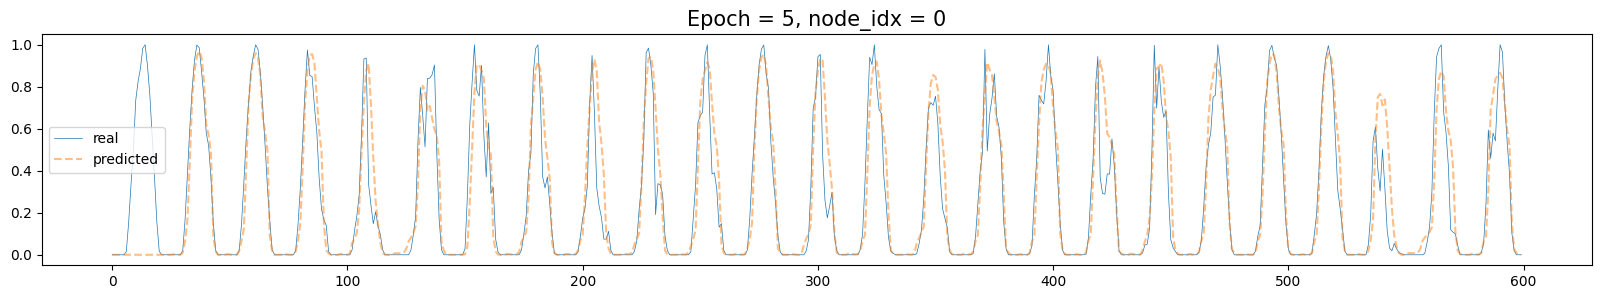

In [20]:
rslt_plot(yP, yPhat, 600)

`-` classic vs. proposed

In [33]:
classic = ((y - yhat)[LEN_TR:,:]**2).mean()
proposed = ((y - yUhat*yPhat)[LEN_TR:,:]**2).mean()
print('classic(mse)', round(classic,4))
print('proposed(mse)', round(proposed,4))

classic(mse) 0.1326
proposed(mse) 0.121

## Edit rgcn

In [88]:
# learn 
def rgcn(FX, model, train_ratio, lags, filters, epoch, batch_size=128, lr=1/1000):
    # step1: create lrnr object
    lrnr = RGCN_Learner()
    # step2: load data
    lrnr.lags = lags
    lrnr.train_ratio = train_ratio
    lrnr.load(FX)
    # step3: construct networks
    lrnr.nof_filters = filters
    lrnr.model = model(node_features=lrnr.lags, filters=lrnr.nof_filters).to(device)
    lrnr.optimizer = torch.optim.Adam(lrnr.model.parameters(), lr=lr)
    # step4: learn
    lrnr.get_batches(batch_size=batch_size)
    for e in range(epoch):
        lrnr.learn()
    yhat = np.concatenate([np.array([list(lrnr.yhat[0])]*lrnr.lags),lrnr.yhat],axis=0)
    return yhat

In [89]:
# hyper params
LAGS = 24
FILTERS = 16
EPOCH = 10

`-` classic

In [78]:
yhat = rgcn(y, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=LAGS, filters = FILTERS, epoch=EPOCH, lr=10/1000)
yhat[yhat<0] = 0

epoch=1  loss=1.218043494969606406117249        
epoch=2  loss=0.667677871882915597415161        
epoch=3  loss=0.4016768541187048912490845   
epoch=4  loss=0.2472662413492798897212982   
epoch=5  loss=0.1823169086128473397854614   
epoch=6  loss=0.1464475668035447631508636   
epoch=7  loss=0.124839798547327520063591        
epoch=8  loss=0.1131234574131667626039505   
epoch=9  loss=0.1051841345615685280317307   
epoch=10     loss=0.099695777986198669304657    

In [79]:
np.mean((y-yhat)[LEN_TR:,:]**2)

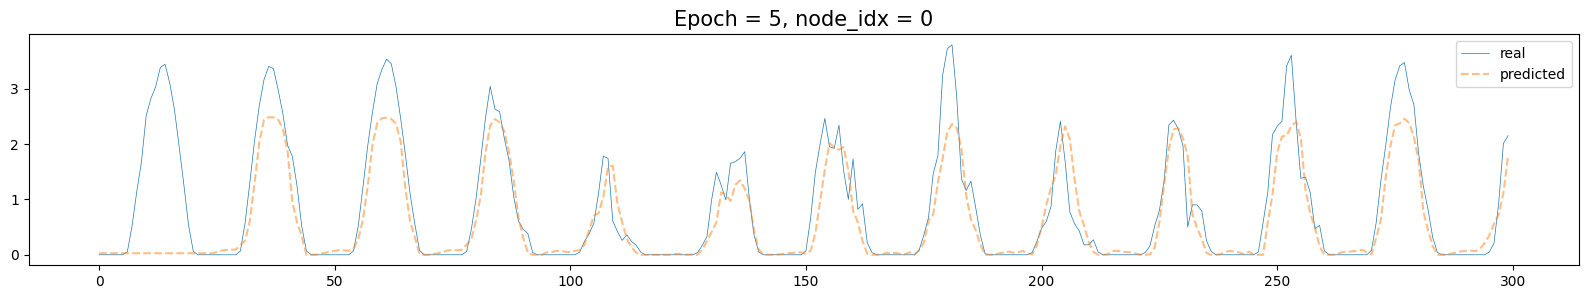

In [80]:
rslt_plot(y, yhat, 300)

`-` proposed

> lag=4, batch size=24, lr=10/1000, epoch=5로 맞추면 될 듯.

In [102]:
# 방법2 
yUhat = rgcn(yU, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=4, filters=FILTERS, epoch=5, batch_size=24, lr=10/1000) # lr=10/1000

epoch=1  loss=2.587332796738591565690613    
epoch=2  loss=0.391898106263820596271896    
epoch=3  loss=0.0831253892677121448984146   
epoch=4  loss=0.0451365663929907499222565   
epoch=5  loss=0.032073326387204457857132        

In [103]:
np.mean((yU-yUhat)[LEN_TR:,:]**2)

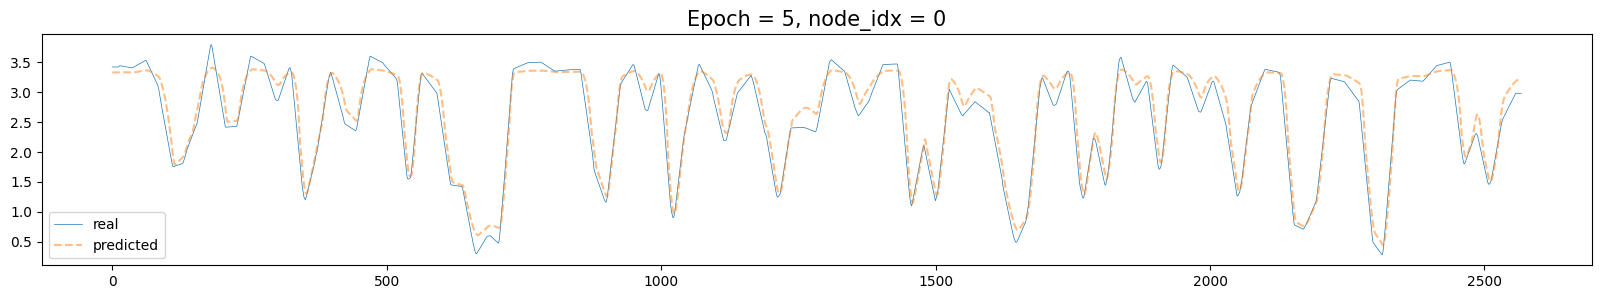

In [104]:
rslt_plot(yU, yUhat)

In [84]:
LAGS, FILTERS, EPOCH

In [95]:
yPhat = rgcn(yP, GConv_LSTM, train_ratio = TRAIN_RATIO, lags=LAGS, filters=FILTERS, epoch=10, lr=10/1000)
yPhat[yPhat < 0] =0 

epoch=1  loss=0.0303973333793692323678112       
epoch=2  loss=0.0198295410955324779322815       
epoch=3  loss=0.0164839075296185967034912       
epoch=4  loss=0.01465522591024637255232239  
epoch=5  loss=0.01332779857330024294278622  
epoch=6  loss=0.01255221158498898141065598  
epoch=7  loss=0.01205595867941156142062664  
epoch=8  loss=0.01178229573997669847239971  
epoch=9  loss=0.01160736384917982181477547  
epoch=10     loss=0.011492302583064884172884        

In [96]:
np.mean((yP-yPhat)[LEN_TR:,:]**2)

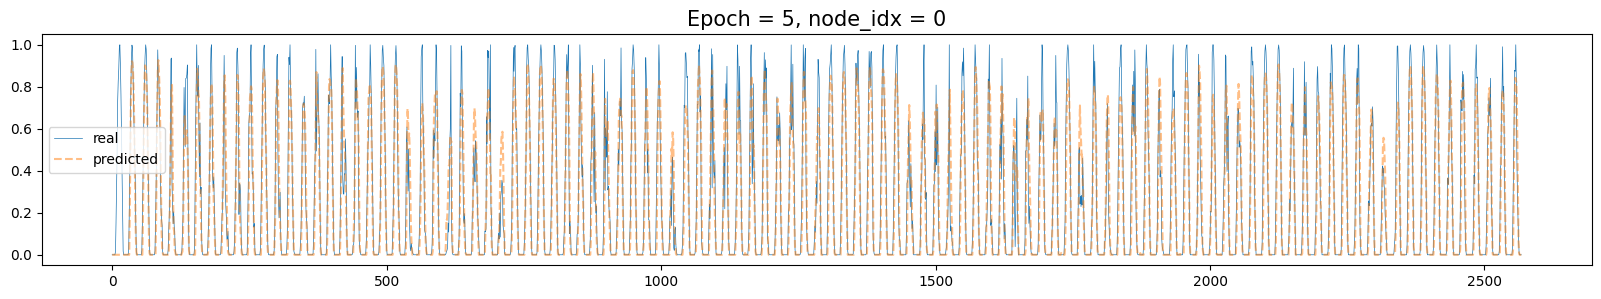

In [97]:
rslt_plot(yP, yPhat)

In [98]:
classic = ((y - yhat)[LEN_TR:, :] ** 2)
proposed = ((y - yUhat*yPhat)[LEN_TR:, :] ** 2)

# print mse
print("""
total_mse(classic): {:.4f}
total_mse(proposed): {:.4f}
""".format(classic.mean(), proposed.mean()))


total_mse(classic): 0.1209
total_mse(proposed): 0.0832


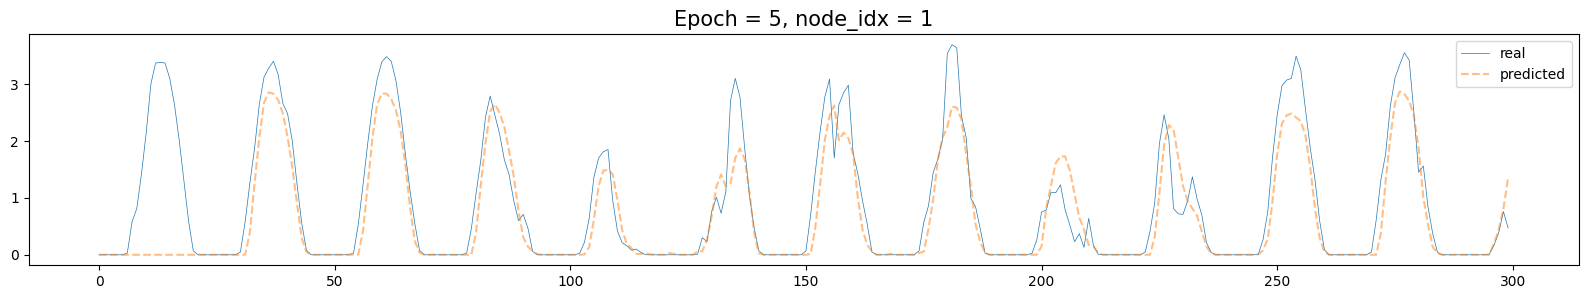

In [99]:
rslt_plot(y, yUhat*yPhat, 300, 1)

## simul code

In [306]:
# for simulation
import itertools
import time
import datetime

class Simulator:
    def __init__(self):
        self.col = ['model', 'method', 'lags', 
       'nof_filters', 'epoch', 'lr', 'calculation_time',
       'index_time',
       'node', 'mse']
        self.df = pd.DataFrame(columns=self.col)
        self.data = pd.read_csv('data_eng_230710.csv')
    
    def simulate(self,n_iteration,lags,filters,epoch,Model,lr):

        # make y, y_upper, y_period, time, regions 
        y = self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].to_numpy()
        yU = self.data.loc[:,'Bukchoncheon_Upper':'Gyeongju-si_Upper'].to_numpy()
        yP = np.divide(y, yU+1e-10)
        t = self.data.loc[:,'date']
        regions = list(self.data.loc[:,'Bukchoncheon':'Gyeongju-si'].columns)
        
        TRAIN_RATIO = 0.8
        T,N = len(t),len(regions) 
        LEN_TEST = int(np.floor(T*(1-TRAIN_RATIO)))
        LEN_TR = T - LEN_TEST        
        
        self.n_iteration = n_iteration
        self.method = ['classic','proposed']
        self.lags = lags
        self.filters = filters
        self.epoch = epoch
        self.Model = Model
        self.lr = lr
        model_name= Model.__name__.replace('_','')

        for iteration in range(n_iteration):
            for m,l,f,e in itertools.product(self.method, self.lags, self.filters, self.epoch):
                if m == 'classic':
                    t1 = time.time()
                    model = self.Model(node_features=l, filters=f) 
                    yhat = rgcn(y, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=128, lr=lr)
                    yhat[yhat < 0]= 0   
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,lr,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                else: # proposed 
                    t1 = time.time()
                    yUhat = rgcn(yU, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=24*2, lr=lr)
                    yPhat = rgcn(yP, Model, train_ratio = TRAIN_RATIO, lags=l, filters=f, epoch=e, batch_size=128, lr=lr)
                    yPhat[yPhat < 0] =0 
                    yhat = yUhat*yPhat
                    t2 = time.time()
                    c = t2-t1
                    t = str(datetime.datetime.now())
                    _df2 = pd.concat([pd.Series(regions),pd.Series(((y - yhat)[LEN_TR:, :] ** 2).mean(axis=0))],axis=1)
                    _df1 = pd.DataFrame([[model_name,m,l,f,e,lr,c,t]]*N)
                    _df = pd.concat([_df1,_df2],axis=1).set_axis(self.col,axis=1)
                    self.df = pd.concat([self.df,_df])
                print("method:{} lag:{} filters:{} epoch:{} is done".format(m,l,f,e))        
            self.df.to_csv("./results/test/GC_LSTM/SOLAR_{}.csv".format(str(pd.to_datetime(datetime.datetime.now())) + str('_') + model_name.lower()),index=False)
            print("save results")

## simulation1 (learning rate = 0.01, 10epoch)

In [288]:
s1 = Simulator()

In [289]:
s1.simulate(
    n_iteration = 4,
    lags = [24],
    filters = [4, 8, 16, 32],
    epoch = [10],
    Model = GC_LSTM,
    lr=0.01
)

epoch=1  loss=0.687569515779614437737274        
epoch=2  loss=0.2720033265650272447213745   
epoch=3  loss=0.188054236117750403345871        
epoch=4  loss=0.149400337599217933429718        
epoch=5  loss=0.1237845667637884683154678   
epoch=6  loss=0.1147598791867494665488434   
epoch=7  loss=0.106392391491681349515686        
epoch=8  loss=0.0994543638080358522334671   
epoch=9  loss=0.0957300071604549940141678   
epoch=10     loss=0.095073992852121598203506    
Early stopping triggered
method:classic lag:24 filters:4 epoch:30 is done
epoch=1  loss=0.920913919806480407701874        
epoch=2  loss=0.2926507610827684429397583   
epoch=3  loss=0.1722068339586258907726288   
epoch=4  loss=0.1312773590907454514568329   
epoch=5  loss=0.1149337189272046164854813   
epoch=6  loss=0.1088088140822947747982025   
epoch=7  loss=0.1040797121822834112794876   
epoch=8  loss=0.1015103748068213523298645   
epoch=9  loss=0.0965603943914175619075775       
epoch=10     loss=0.09687638329342008205856

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

## simul result (lr=0.01)

In [47]:
import os
fnames = ['./results/test/GConv_LSTM/'+l for l in os.listdir('./results/test/GConv_LSTM') if l[0] != '.']
fnames 

In [ ]:
df = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)
df.head()

In [ ]:
df.groupby(by=['method','nof_filters']).agg({'mse':[np.mean, np.std]}) # learning rate = 10/1000

In [307]:
s2 = Simulator()

In [ ]:
s2.simulate(
    n_iteration = 4,
    lags = [24],
    filters = [4, 8, 16, 32],
    epoch = [30],
    Model = GC_LSTM,
    lr = 0.01
)

epoch=1  loss=1.23143585398793220712738         
epoch=2  loss=0.690700471401214624156189        
epoch=3  loss=0.479652076959613049030304        
epoch=4  loss=0.3722178861498832701504517   
epoch=5  loss=0.304831931367516550013733        
epoch=6  loss=0.2572752153500914668077087   
epoch=7  loss=0.2206070153042674039596558   
epoch=8  loss=0.19220586679875854457016         
epoch=9  loss=0.1693057748489081946710205   
epoch=10     loss=0.15122878877446055993576     
epoch=11     loss=0.135982095263898379490509    
epoch=12     loss=0.123230142053216767017746    
epoch=13     loss=0.11406752280890942820694     
epoch=14     loss=0.108035833109170248131561    
epoch=15     loss=0.10461505316197872170578     
epoch=16     loss=0.101713771931827077484589    
epoch=17     loss=0.099456349387764935402832    
epoch=18     loss=0.097743962425738579719391    
epoch=19     loss=0.096081108786165715644913    
epoch=20     loss=0.094543373212218286706238    
epoch=21     loss=0.0934464503079652

In [ ]:
import os
fnames = ['./results/test/GC_LSTM/'+l for l in os.listdir('./results/test/GC_LSTM') if l[0] != '.']
fnames 

In [ ]:
df = pd.concat([pd.read_csv(fname) for fname in fnames]).reset_index(drop=True)
df.head()

In [ ]:
df.groupby(by=['method','nof_filters']).agg({'mse':[np.mean, np.std]}) # learning rate = 10/1000